In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
from scipy import stats

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

### Load up sipms and PDFs

In [52]:
simps_x = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_x_{}.txt".format(station))
    simps_x.append(data)

In [53]:
simps_y = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_y_{}.txt".format(station))
    simps_y.append(data)

In [143]:
depths = [291,295,304,308,317,321,330,334,343,347]
PDFs_x = []

for depth in depths:
    for station in range(1,6):
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_x_{}.txt".format(depth,station)
        data = np.loadtxt(path)
        PDFs_x.append(data)

In [144]:
depths = [291,295,304,308,317,321,330,334,343,347]
PDFs_y = []

for depth in depths:
    for station in range(1,6):
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_y_{}.txt".format(depth,station)
        data = np.loadtxt(path)
        PDFs_y.append(data)

In [145]:
PDFs_x = np.array(PDFs_x)

In [146]:
PDFs_x += 0.00005

In [147]:
PDFs_y = np.array(PDFs_y)

In [148]:
PDFs_y += 0.00005

### Check how PDFs look

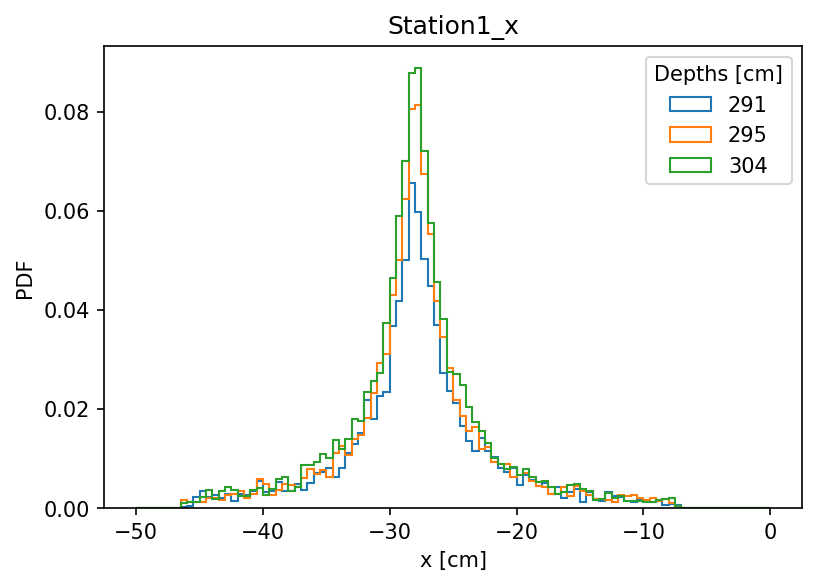

In [149]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for depth in [291,295,304]:#,308,317,321,330,334,343,347]:
    PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_50/PDF/PDF_x_5.txt".format(depth))
    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF,histtype="step",
                        label=[str(depth)])

plt.xlabel("x [cm]")
plt.ylabel("PDF")
plt.title("Station1_x")
plt.legend(title="Depths [cm]")

# plt.savefig("station1_x_energies.png")
plt.show()

### Depth reconstruction

In [67]:
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

for energy in energies:
    depths = [291,295,304,308,317,321,330,334,343,347]
    PDFs_x = []

    for depth in depths:
        for station in range(1,6):
            path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/PDF_x_{}.txt".format(depth,energy,station)
            data = np.loadtxt(path)
            PDFs_x.append(data)

    # energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
    depths = [291,295,304,308,317,321,330,334,343,347]
    PDFs_y = []

    for depth in depths:
        for station in range(1,6):
            path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/PDF_y_{}.txt".format(depth,energy,station)
            data = np.loadtxt(path)
            PDFs_y.append(data)


    PDFs_x = np.array(PDFs_x)

    PDFs_x += 0.00005

    PDFs_y = np.array(PDFs_y)

    PDFs_y += 0.00005

    ###
    # Main code to reconstruct depth using the hits and PDFs
    # Only x-plane reconstruction
    ###

    t1 = time.perf_counter()
    # r2_vals = []

    depths = [291,295,304,308,317,321,330,334,343,347]
    energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

    logL_x_list = []

    reco_z_x_list = []
    reco_z_x = np.array([])
#     reco_z_y = np.array([])
#     reco_z_comb = np.array([])        

    for true_z_num, true_z in enumerate(depths):
        hit_counts_x_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/events/hits_x.txt".format(true_z,energy))
        hit_counts_x_list = hit_counts_x_list.values.tolist()

        for event in range(1,101):

            sum_log_x = np.zeros(10)

            for depth_num, starting_depth in enumerate(depths):

                logL_x = 0

                for station in range(1,6):

                    SiPM_counts_x = simps_x[station-1]

                    hit_counts_x = hit_counts_x_list[(5*(event-1))+(station-1)]


                    PDF_x = PDFs_x[(depth_num*5)+(station-1)]

                    logL_x += np.sum(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                                        ((hit_counts_x)*np.log(PDF_x)))

                    logL_x_list.append(np.sum(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                                        ((hit_counts_x)*np.log(PDF_x))))

                sum_log_x[depth_num] = logL_x


            reco_z_x = np.append(reco_z_x,depths[np.argmax(sum_log_x)])

    reco_z_x_list.append(reco_z_x)

    reco_z_x_df = pd.DataFrame(reco_z_x_list)   

    reco_z_x_df.to_csv("/eos/user/s/skatsaro/PGsim/reco_depth_e_{}_2/reco_z_x.txt".format(energy), encoding="utf-8", index=False)

    t2 = time.perf_counter()
    print(t2-t1)

4.798498693853617
5.861419260501862
8.983569979667664
5.663671225309372
5.715801311656833
5.361461468040943
5.8151118494570255
5.536419173702598
6.826302915811539
5.97713159956038
5.643314599990845


### Make plots and diagnostics

In [18]:
depths = [291,295,304,308,317,321,330,334,343,347]
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

In [93]:
true_z = np.array([])
for z in depths:
    for i in range(0,100):
    
        true_z = np.append(true_z,z)

In [134]:
bias = []
res = []
for energy in energies:
    
    reco_z_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/reco_depth_e_{}_2/reco_z_x.txt".format(energy))
    reco_z_x = np.ndarray.flatten(reco_z_x.values)
#     reco_avg = np.average(reco_e_x.reshape(11,100),axis=1)
#     reco_std = np.std(reco_e_x.reshape(11,100),axis=1)
    
    bias_z = np.average(((reco_z_x-true_z)).reshape(10,100),axis=1)
    res_z = np.std(((reco_z_x-true_z)).reshape(10,100),axis=1)
    bias.append(bias_z)
    res.append(res_z)
#     resolution.append(reco_std)

In [139]:
res = np.array(res)

In [140]:
bias = np.array(bias)

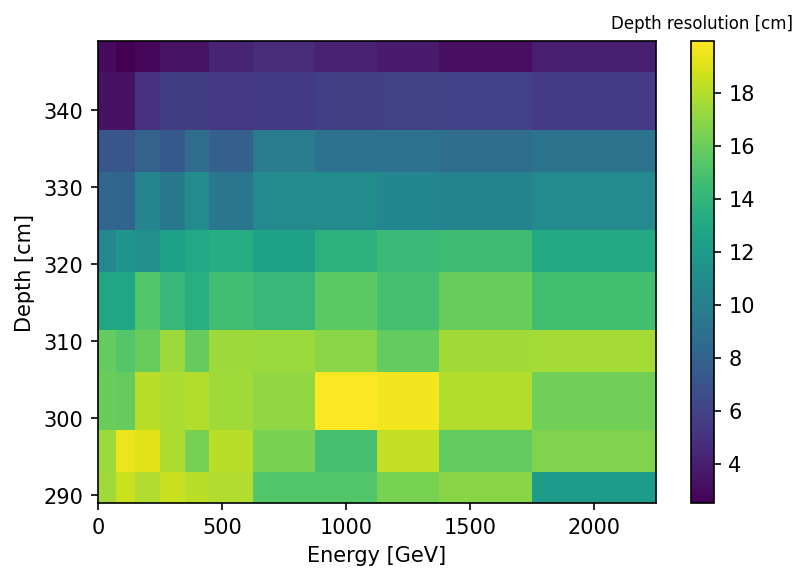

In [88]:
###
# Make bias and resolution plot by just changing the variable in weights
###

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
bins = [289,293,298.5,306,311.5,319,324.5,332,337.5,345,349]

plt.hist2d(np.repeat(energies,10),np.tile(depths,11),bins = [[0,75,150,250,350,450,625,875,1125,1375,1750,2250],bins],
                                                             weights=np.ndarray.flatten(np.array(res)))
# plt.xticks(np.linspace(1,5.5,10))
plt.xlabel("Energy [GeV]")
plt.ylabel("Depth [cm]")
# plt.set_cmap('viridis') 
clb = plt.colorbar(ax=ax)
clb.ax.set_title("Depth resolution [cm]", fontsize=8)
# plt.savefig("Res reco depth, all depths and energies (updated,absolute)2.png",bbox_inches="tight")

plt.show()

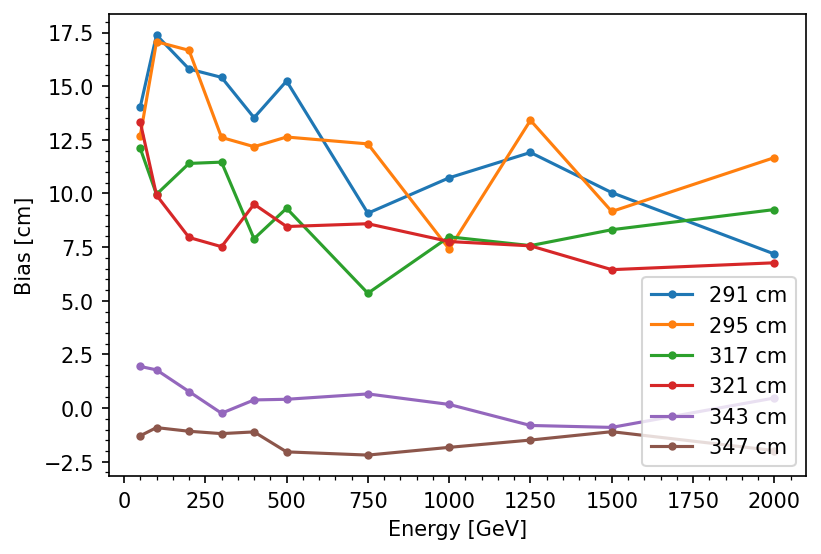

In [142]:
###
# Make bias and resolution plot by just changing the variable in plt.plot
###

energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
# energies_sub = [50,300,750,1250,2000]

depth_sub = [291,295,317,321,343,347]
legend_depth = [str(x) + " cm" for x in depth_sub]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for num_z, depth in enumerate(depth_sub):
    

    plt.plot(energies,bias[:,np.where(np.array(depths)==depth)[0]],marker=".")
#     plt.errorbar(depths,deltas[:,num_e],yerr=stds[:,num_e]/2,linestyle="")
    plt.xlabel("Energy [GeV]")
    plt.ylabel("Bias [cm]")
    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
#     plt.title("Energy reco. {} GeV".format(energy))
    
plt.legend(legend_depth)
# plt.savefig("Bias reco depth, [291, 295, 317, 321, 343, 347] cm, all energies (updated,absolute)2.1.png",bbox_inches="tight")
plt.show()

### Summary energy reconstruction per depth

In [113]:
for energy in [1000]:
    reco_z_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/reco_depth_e_{}_2/reco_z_x.txt".format(energy))
    reco_z_x = np.ndarray.flatten(reco_z_x.values)

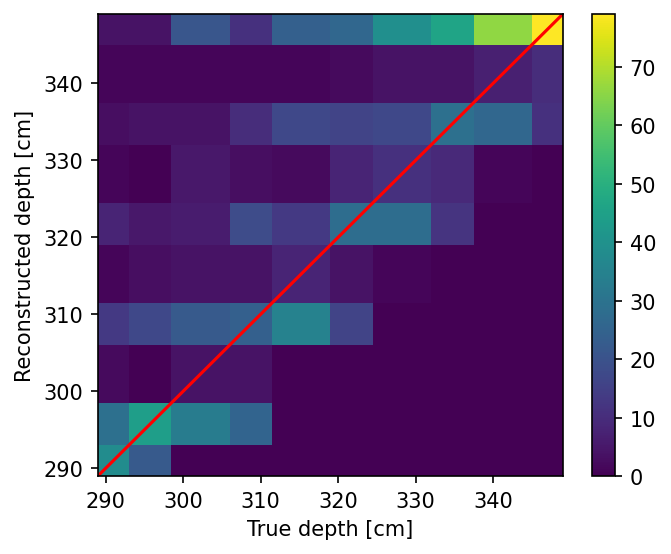

In [115]:
bins = [289,293,298.5,306,311.5,319,324.5,332,337.5,345,349]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_z,np.ndarray.flatten(np.array(reco_z_x)),bins = [bins,bins])
plt.ylabel("Reconstructed depth [cm]")
plt.xlabel("True depth [cm]")

plt.colorbar()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")
plt.show()

### Breaking down depth reco for individual events

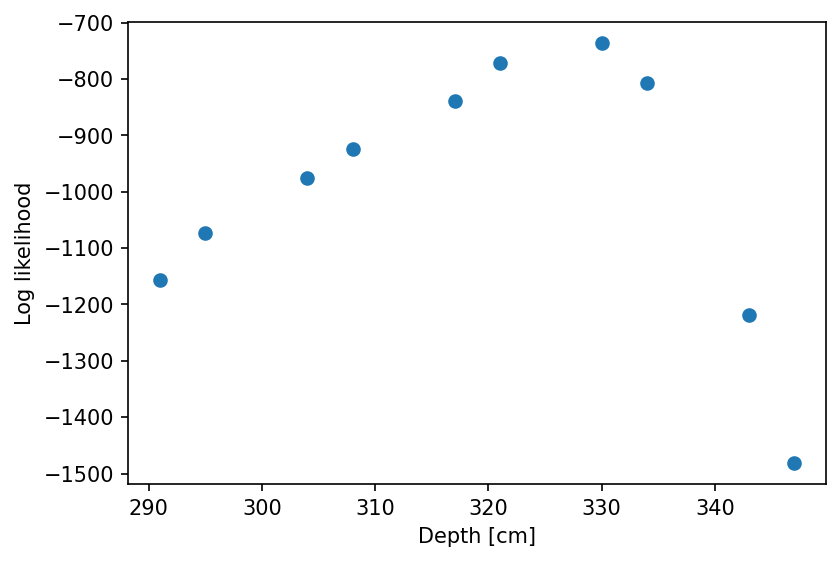

In [140]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

plt.scatter(depths,sum_log_x)
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
# plt.legend(title="Station")
# plt.savefig("combined logL for 304cm 300 GeV example (depth reco)(evt_2).png",bbox_inches="tight")
plt.show()

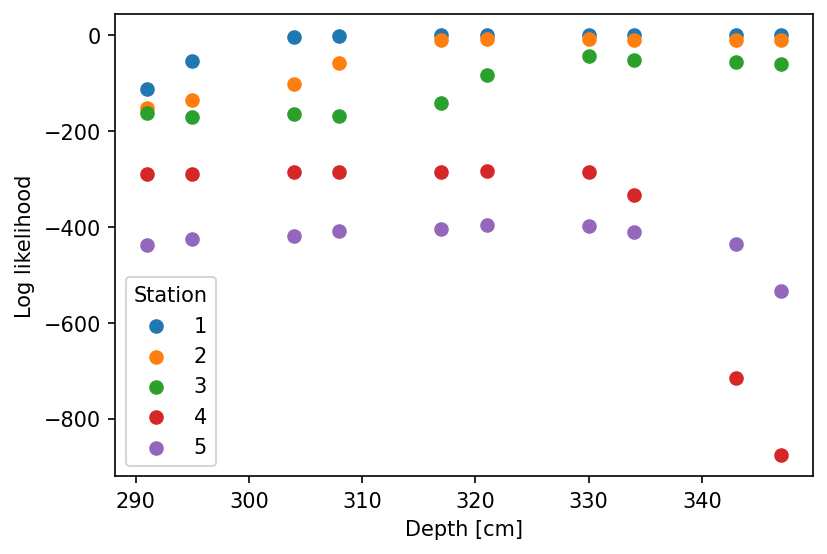

In [142]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for i in range(0,5):

    plt.scatter(depths,np.array(logL_x_list).reshape(10,5).T[i],label=i+1)
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
plt.legend(title="Station")
# plt.savefig("per station logL for 304cm 300 GeV example(depth reco)(evt_2).png",bbox_inches="tight")
plt.show()